## Notebook 10.6
Discrete and continuous random variates in pymc3 Bayesian model fitting. 

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

### A novel implementation
For this notebook we will be examining a case study similar to the ["Case study 2"](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters) in the pymc3 quickstart guide. Here they use a `switchpoint` model that combines several really interesting and powerful methods that are pretty unique to pymc3. This includes the ability to combine continuous and categorical data into model and using different MCMC sampling methods for each of them. Here we combine continuous data (exponentially distributed values), binary data (missing or not), and discrete data (years), each of which use a different sampler. 

### Generate some data
The "Case study 2" dataset investigates data on mining disasters to ask whether there is a detectable switchpoint at which the frequency of disasters changed. Instead of using the test data that they provide, let's simulate data on our own that will look the same as the test data. Here, I create a dataframe with years from 1800-2015, and then I draw random values from a [poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with a different rate parameter (expected number of events) before or after a certain year (1920). Our goal is to accurately reconstruct when that switchpoint is, as well as what the rate parameters are before and after it. 

In [2]:
# fix a random seed
np.random.seed(12345)

# generate data for 199 years with higher rates before 1920
data = pd.DataFrame({
    "year": np.arange(1800, 2015),
    "disasters": np.concatenate([
        np.random.poisson(5.0, 120),
        np.random.poisson(2.5, 95),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "disasters"] = np.nan

In [3]:
data.head()

,disasters,year
0,4.0,1800
1,7.0,1801
2,7.0,1802
3,8.0,1803
4,3.0,1804


In [4]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.disasters, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N disasters",
);

1800 1900 2000 year 0 4 8 12 N disasters

### Build the model
Here I build my model the same way that they do in the tutorial. I learned from their example. It makes sense to me now how this model works after testing it thoroughly and reading their explanation. 

In [5]:
with pm.Model() as disaster_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1900)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=data.disasters)

In [6]:
with disaster_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
100%|██████████| 10500/10500 [00:35<00:00, 291.85it/s]


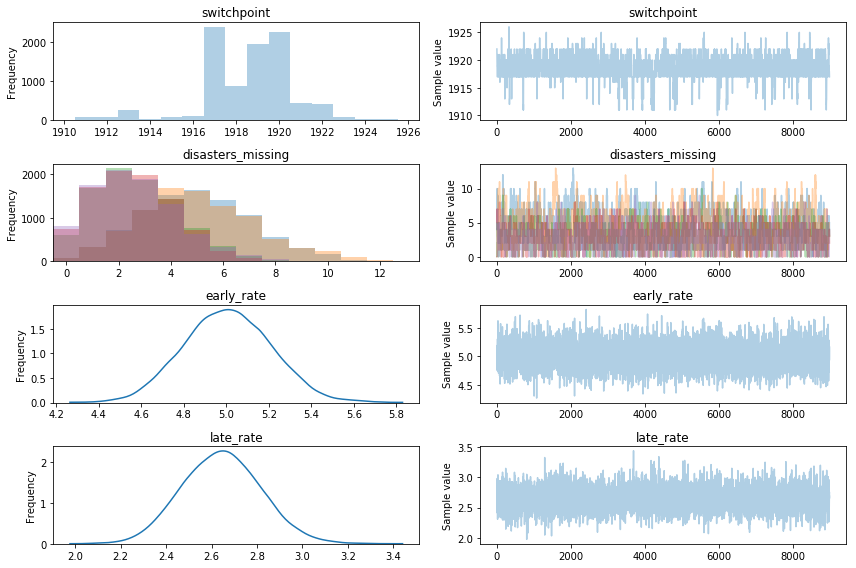

In [7]:
pm.traceplot(trace[1000:]);

### Some very cool features:

1. We correctly estimate the switchpoint: The posterior mean estimate is close to 1920. But we also get confidence intervals around this value, with the 95% HPD including ~1910-1930. 
    
2. The early and late rates before and after the switch were estimated correctly. These were modeled as exponential random variates -- the expected number of disasters per year. 

3. The *missing data* has values inferred for it. Here the model simulates data for the missing values based on the model fit for data in that part of the switchpoint. Therefore, missing values before or after the switchpoint have different mean posterior values inferred. 

In [8]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1918.585         2.075            0.076            [1913.000, 1922.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1913.000       1917.000       1919.000       1920.000       1922.000


disasters_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.924            2.143            0.117            [1.000, 9.000]
  4.996            2.200            0.129            [1.000, 9.000]
  2.718            1.664            0.072            [0.000, 6.000]
  2.656            1.615            0.066            [0.000, 5.000]
  2.599            1.644            0.068            [0.000, 6.000]

  Posterior quantiles:
  2.5     